In [1]:
import sys
sys.path.append('/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample')
import torch
import torchvision
torch.manual_seed(5)

from src.network.Classification import LLVIClassification
from src.network import LikApprox, PredictApprox
from src.weight_distribution.Full import FullCovariance
from datetime import datetime

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 22,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [3]:
batch_size_train = 32
filepath = "/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample/datasets/Classification"
dataset = torchvision.datasets.MNIST(filepath, train=True, download=False,
                            transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ]))
train_size = int(0.1 * len(dataset))
rest_size = len(dataset) - train_size                            
dataset, _ = torch.utils.data.random_split(dataset, [train_size, rest_size])
train_loader = torch.utils.data.DataLoader(dataset,
  batch_size=batch_size_train, shuffle=True)
n_datapoints = batch_size_train * len(train_loader)

/opt/homebrew/Caskroom/miniforge/base/envs/DeepLearning/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1635217266490/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
from torch import nn, optim
class VICNN(nn.Module):
    def __init__(self, feature_dim=50, optimizer=optim.Adam, **optim_kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, feature_dim)
        self.optimizer: optim = optimizer(self.parameters(), **optim_kwargs)
        self.nonll = torch.sigmoid # nonlinear layer

    def forward(self, x):
        x = self.pool(self.nonll(self.conv1(x)))
        x = self.pool(self.nonll(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.nonll(self.fc1(x))
        x = self.nonll(self.fc2(x))
        return x

In [5]:
# go over all mc methods
lr = 1e-4
samples_list = [1,10]
mc_train_losses = []
mc_train_times = []
for samples in samples_list:
    print("Starting run", samples)
    feature_extractor = VICNN(optimizer=torch.optim.Adam, lr=lr, weight_decay=5e-4)
    dist = FullCovariance(50, 10, lr=lr)
    net_mc = LLVIClassification(50, 10, feature_extractor, dist,
    prior_log_var=-1, optimizer_type=torch.optim.Adam,
    tau=0.1, lr=lr)
    start_time = datetime.now()
    train_loss = net_mc.train_model(train_loader, epochs=50, n_datapoints=n_datapoints, samples=samples, method=LikApprox.MONTECARLO)
    total_time = int((datetime.now() - start_time).total_seconds())
    mc_train_losses.append(train_loss)
    mc_train_times.append(total_time)

Starting run 1


prediction_loss:2.31 kl_loss:0.09: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it]


Starting run 10


prediction_loss:2.3 kl_loss:0.12: 100%|██████████| 50/50 [03:14<00:00,  3.88s/it] 


In [37]:
approx_list = ["bohning", "multidelta"] # "jennsen" (gives nan for this example)
cf_train_losses = []
cf_train_times = []
for approx_name in approx_list:
    print("Starting approx", approx_name)
    feature_extractor = VICNN(optimizer=torch.optim.Adam, lr=lr, weight_decay=5e-4)
    dist = FullCovariance(50, 10, lr=lr)
    net_cf = LLVIClassification(50, 10, feature_extractor, dist,
    prior_log_var=-1, optimizer_type=torch.optim.Adam,
    tau=0.1, lr=lr)
    start_time = datetime.now()
    train_loss = net_cf.train_model(train_loader, epochs=50, n_datapoints=n_datapoints, samples=5, method=LikApprox.CLOSEDFORM, approx_name=approx_name)
    cf_train_losses.append(train_loss)
    cf_train_times.append(int((datetime.now() - start_time).total_seconds()))

Starting approx jennsen


prediction_loss:nan kl_loss:nan:   2%|▏         | 1/50 [00:06<05:12,  6.39s/it]


KeyboardInterrupt: 

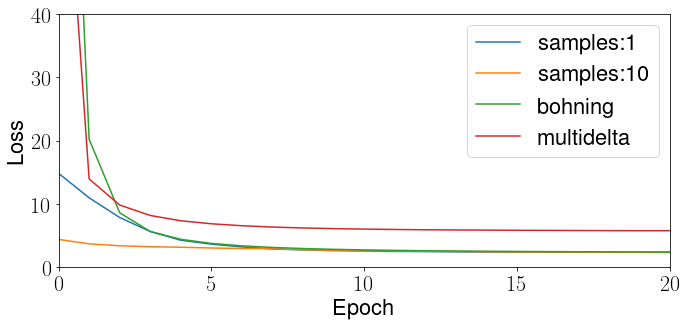

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
# visualization
vi_train_epochs=50
for samples, train_loss, train_time in zip(samples_list, mc_train_losses, mc_train_times):
    ax.plot(list(range(vi_train_epochs)), (train_loss["prediction_loss"]), label=f"samples:{samples}")

for approx_name, train_loss, train_time in zip(approx_list, cf_train_losses, cf_train_times):
    ax.plot(list(range(vi_train_epochs)), (train_loss["prediction_loss"]), label=f"{approx_name}") 

ax.legend()
ax.set_ylim(0, 40)
ax.set_xlim(0, 20)
ax.set_xticks([0, 5, 10, 15, 20])
# fig.suptitle("Monte Carlo vs Closed Form Classification Loss comparison")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
fig.tight_layout()
# fig.savefig("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/presentations/presentation_11_1/images/Classification/MCvsCF.jpg")